# Environment

In [1]:
import os
import io
import json
import requests
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from collections import namedtuple
from glob import glob

In [2]:
# download the training logs
logs_dir = 'training_output'
if not os.path.exists(logs_dir):
    r = requests.get("https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2Fpaper_training_output.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(logs_dir)

# Plot a single model

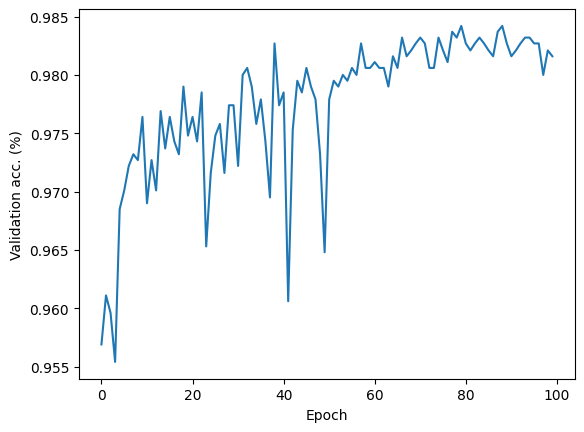

In [31]:
model_name = 'FasterRCNN_FPN_800_square'
train_log = pd.read_csv(f'{logs_dir}/{model_name}_0/train_log.csv')
va = train_log.valid_accuracy.tolist()
plt.plot(va, label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Validation acc. (%)')
plt.show()

# Load all training logs

In [32]:
# create dicts with model validation and test accuracies
va_dict = defaultdict(list)
ta_dict = defaultdict(list)

# iterate through model directories
for model_dir in sorted(glob(f'{logs_dir}/*')):
    
    # get model id based on model directory
    model_id = model_dir.split('/')[-1]
    
    # split model_id into model_name and training_iter
    model_name, _ = model_id.rsplit('_', 1)
    
    # read validation accuracy from training logs 
    train_log = pd.read_csv(f'{model_dir}/train_log.csv')
    va = train_log.valid_accuracy.tolist()
    
    # append logs if they're the first logs of the given model
    # or if they're of the same length as the previous logs
    # (avoid storing logs of a model that hasn't finished trainig yet) 
    if len(va_dict[model_name]) == 0 or len(va_dict[model_name][0]) == len(va):
        # read test accuracy from test logs
        with open(f'{model_dir}/test_logs.json') as f:
            ta = json.load(f)['accuracy']
            
        va_dict[model_name] += [va]
        ta_dict[model_name] += [ta]

# compute accuracy mean and SE for each model
Logs = namedtuple('Logs', ['va_mean', 'va_se', 'ta_mean', 'ta_se'])
logs = {}
for k, v in va_dict.items():
    # print number of training iters for each model
    print(f'{k}: {len(v)}')

    # calculate the mean and standard error of valid. accuracy
    va = np.array(v)
    # va = np.array([ma(x, 10) for x in va])
    va_mean = np.mean(va, 0)
    va_se = np.std(va, 0) / np.sqrt(va.shape[0])
    
    # calculate the mean and standard error of test accuracy
    ta = np.array(ta_dict[k])
    ta_mean = np.mean(ta)
    ta_se = np.std(ta) / np.sqrt(len(ta))
    
    # save validation and test logs
    logs[k] = Logs(va_mean, va_se, ta_mean, ta_se)

training_output\FasterRCNN_FPN_1100_square: 4
training_output\FasterRCNN_FPN_1440_square: 5
training_output\FasterRCNN_FPN_800_square: 5
training_output\RCNN_128_square: 5
training_output\RCNN_256_square: 5
training_output\RCNN_64_square: 5


# Compare models

In [33]:
def ma(x, w=10):
    """Moving average."""
    return np.convolve(x, np.ones(w), 'valid') / w

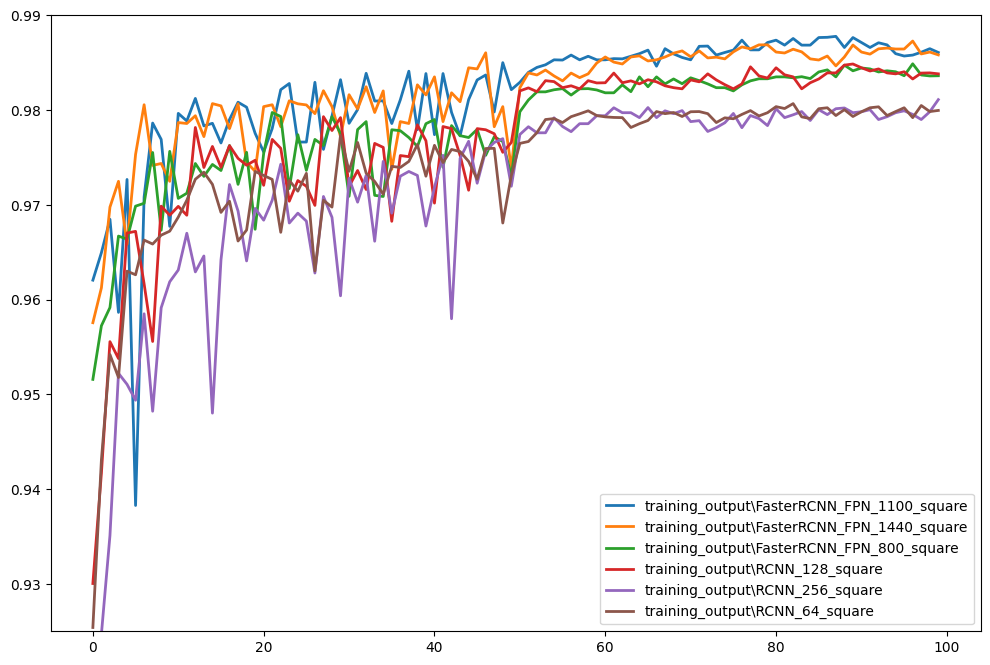

In [34]:
fig, ax = plt.subplots(figsize=[12, 8])
for k, v in logs.items():
    epochs = np.arange(len(v.va_mean))
    plt.plot(epochs, v.va_mean, label=k, linewidth=2)
ax.legend()
ax.set_ylim([0.925, 0.99])
plt.show()

In [35]:
# create a dataframe with model accuracies
df = pd.DataFrame(columns=['Architecture', 'Pooling', 'Resolution', 'Valid. accuracy [\%]', 'Test accuracy [\%]'])
for i, (k, v) in enumerate(logs.items()):
    model_name, res, pooling = k.rsplit('_', 2)
    model_name = {'RCNN': 'R-CNN', 'FasterRCNN_FPN': 'Faster R-CNN FPN'}[model_name]
    pooling = {'qdrl': 'quadrilateral', 'square': 'square'}[pooling]
    va_str = f'{100*v.va_mean[-1]:.2f} $\pm$ {100*v.va_se[-1]:.2f}' # valid. accuracy
    ta_str = f'{100*v.ta_mean:.2f} $\pm$ {100*v.ta_se:.2f}' # test accuracy
    df.loc[i] = [model_name, pooling, res, va_str, ta_str]

KeyError: 'training_output\\FasterRCNN_FPN'

In [ ]:
# sort the dataframe
df['Resolution'] = df['Resolution'].astype(int)
df = df.sort_values(['Architecture', 'Pooling', 'Resolution'], ascending=[True, False, False])
df

,Architecture,Pooling,Resolution,Valid. accuracy [\%],Test accuracy [\%]
3,Faster R-CNN FPN,square,1440,98.58 $\pm$ 0.07,98.51 $\pm$ 0.10
1,Faster R-CNN FPN,square,1100,98.54 $\pm$ 0.11,98.52 $\pm$ 0.11
5,Faster R-CNN FPN,square,800,98.36 $\pm$ 0.07,98.31 $\pm$ 0.08
2,Faster R-CNN FPN,quadrilateral,1440,98.34 $\pm$ 0.10,98.31 $\pm$ 0.09
0,Faster R-CNN FPN,quadrilateral,1100,98.28 $\pm$ 0.14,98.00 $\pm$ 0.08
4,Faster R-CNN FPN,quadrilateral,800,97.80 $\pm$ 0.07,97.97 $\pm$ 0.14
9,R-CNN,square,256,98.11 $\pm$ 0.07,97.62 $\pm$ 0.07
7,R-CNN,square,128,98.38 $\pm$ 0.06,97.97 $\pm$ 0.07
11,R-CNN,square,64,98.00 $\pm$ 0.08,97.73 $\pm$ 0.13
8,R-CNN,quadrilateral,256,96.39 $\pm$ 0.15,96.08 $\pm$ 0.12
